# Graph embedding using SkipGram

This is an embedding of the whole graph, no training and validation split and all sources.

In [38]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

In [39]:
exp_name = "80_20_training_test_epoch_500_delta_0.0001"
graph_data_dir = "graph"

## Loading the graphs
We load the ppi graph from the repository as an undirected graph.

In [40]:
import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)
if not os.path.exists(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz"):
    with urllib.request.urlopen("https://zenodo.org/record/4011267/files/kg-covid-19-skipgram-aug-2020.tar.gz") as response, \
        open(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz", 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [41]:
import os
os.system("tar -xvzf " + graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz -C " + graph_data_dir)

0

In [42]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path= graph_data_dir + "/merged-kg_edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    default_edge_type="biolink:association",
    node_path= graph_data_dir + "/merged-kg_nodes.tsv",
    nodes_column="id",
    node_types_column="category",
    default_node_type="biolink:NamedThing",
    ignore_duplicated_edges=True,
    ignore_duplicated_nodes=True,
    force_conversion_to_undirected=True
)

As first thing, we print a short report showing all the avalable graph details, including the number of edges, nodes, trap nodes and both the connected components and the strongly connected components.

In [43]:
graph.report()

{'selfloops_rate': '0.000015391581103247148',
 'connected_components_number': '8976',
 'degrees_median': '6',
 'traps_rate': '0.021906677500566116',
 'strongly_connected_components_number': '8976',
 'degrees_mode': '1',
 'nodes_number': '375365',
 'bidirectional_rate': '1',
 'unique_edge_types_number': '0',
 'degrees_max': '90378',
 'unique_node_types_number': '36',
 'is_directed': 'false',
 'density': '0.00021902960686152735',
 'degrees_min': '0',
 'singleton_nodes': '8223',
 'degrees_mean': '82.21604837957722',
 'edges_number': '30861027'}

The followings are check that are not necessary, but are offered as sanity checks:

### Considered parameters
We are going to use the following parameters:

- **Walk lengths:** $100$ nodes.
- **Batch size:** $2^{7} = 128$ walks per batch.
- **Walk iterations:** $20$ iterations on the graph.
- **Window size:** $4$ nodes, meaning $4$ on the left and $4$ on the right of the center nodes. Consider that the first *window_size* values on the left and the right of the walks will be trimmed.
- **Return weight, inverse of $p$:** $1.0$.
- **Explore weight, inverse of $q$:** $1.0$.
- **Embedding size:** $100$.
- **Negative samples:** For the porpose of the [NCE function negative samples](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss), we are going to use $10$. These are the number of negative classes to randomly sample per batch. This single sample of negative classes is evaluated for each element in the batch.
- **Optimizer:** [Nadam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam).
- **Early stopping parameters:** We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.
- **Epochs:** The model will be trained up to $1000$ epochs.
- **Learning rate:** since tipically the loss function is quite convex for the embedding problem, we can use a relatively higher learning rate. We are going to us $0.1$ for this example, to get to a faster convergence: this might lead to skipping some better minima that might be identified with a lower learning rate, such as the default one which is $0.0001$.

In [44]:
training, validation = graph.connected_holdout(42, 0.8)

In [45]:
training.report()

{'traps_rate': '0.021933318236916067',
 'nodes_number': '375365',
 'bidirectional_rate': '1',
 'density': '0.0001752236883281372',
 'strongly_connected_components_number': '8976',
 'degrees_mean': '65.77283976929122',
 'unique_node_types_number': '36',
 'is_directed': 'false',
 'degrees_min': '0',
 'degrees_max': '71988',
 'degrees_mode': '1',
 'degrees_median': '5',
 'singleton_nodes': '8233',
 'edges_number': '24688822',
 'unique_edge_types_number': '0',
 'selfloops_rate': '0.000014743514291609376',
 'connected_components_number': '8976'}

In [46]:
validation.report()

{'singleton_nodes': '158280',
 'selfloops_rate': '0.00001798384855979346',
 'degrees_max': '18390',
 'degrees_mode': '0',
 'bidirectional_rate': '1',
 'density': '0.000043805918533390134',
 'connected_components_number': '162705',
 'degrees_mean': '16.44320861028599',
 'traps_rate': '0.42166957494705154',
 'unique_node_types_number': '36',
 'unique_edge_types_number': '0',
 'is_directed': 'false',
 'nodes_number': '375365',
 'strongly_connected_components_number': '162705',
 'degrees_median': '1',
 'degrees_min': '0',
 'edges_number': '6172205'}

In [47]:
assert graph > training
assert graph > validation
assert (training + validation).contains(graph)
assert graph.contains(training + validation)
assert not training.overlaps(validation)
assert not validation.overlaps(training)

#### Setting up the parameters

In [48]:
walk_length=100
batch_size=2**9
iterations=20
window_size=4
p=1.0
q=1.0
embedding_size=100
negatives_samples=30
patience=5
delta=0.0001
epochs=500
learning_rate=0.1

#### Creating the training and validation Keras sequences

## Creating the SkipGram model
We are going to setup the model to use, if available, multiple GPUs.

In [49]:
from embiggen import Node2VecSequence

training_sequence = Node2VecSequence(
    training,
    walk_length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

validation_sequence = Node2VecSequence(
    graph, # Here we use the entire graph. This will only be used for the early stopping.
    walk_length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

In [50]:
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.optimizers import Nadam
from embiggen import SkipGram

strategy = MirroredStrategy()
with strategy.scope():
    model = SkipGram(
        vocabulary_size=training.get_nodes_number(),
        embedding_size=embedding_size,
        window_size=window_size,
    negatives_samples=negatives_samples,
    optimizer=Nadam(learning_rate=learning_rate)
    )

model.summary()

Model: "SkipGram"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       37536500    words_embedding[0][0]            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 8)]          0                                            
___________________________________________________________________________________________

## Tuning the SkipGram model

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    training_sequence,
    steps_per_epoch=training_sequence.steps_per_epoch,
    validation_data=validation_sequence,
    validation_steps=validation_sequence.steps_per_epoch,
    epochs=epochs,
    callbacks=[
        EarlyStopping(
            "val_loss",
            min_delta=delta,
            patience=patience,
            restore_best_weights=True
        )
    ]
)

Epoch 1/500
718/718 [==============================] - 1272s 2s/step - loss: 53.2450 - val_loss: 37.3300
Epoch 2/500
718/718 [==============================] - 1267s 2s/step - loss: 30.0708 - val_loss: 34.1020
Epoch 3/500
718/718 [==============================] - 1265s 2s/step - loss: 29.1847 - val_loss: 30.3964
Epoch 4/500
718/718 [==============================] - 1261s 2s/step - loss: 25.3538 - val_loss: 27.8371
Epoch 5/500
718/718 [==============================] - 1267s 2s/step - loss: 23.3210 - val_loss: 25.9948
Epoch 6/500
718/718 [==============================] - 1266s 2s/step - loss: 22.4200 - val_loss: 25.6218
Epoch 7/500
718/718 [==============================] - 1266s 2s/step - loss: 21.3047 - val_loss: 24.0166
Epoch 8/500
718/718 [==============================] - 1265s 2s/step - loss: 20.1007 - val_loss: 22.9065
Epoch 9/500
718/718 [==============================] - 1269s 2s/step - loss: 19.5533 - val_loss: 22.4711
Epoch 10/500
718/718 [==============================] -

In [52]:
### Saving the model weights
# We save the obtained model weights:

In [53]:
model.save_weights(f"{model.name}_" + exp_name + "_weights.h5")

### Visualizing the training history
We can visualize the performance of the model during the training process as follows:

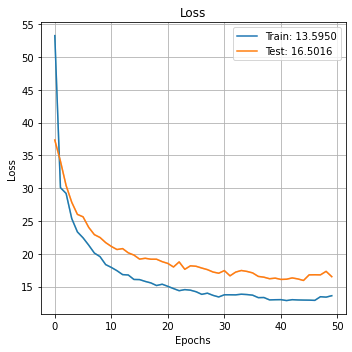

In [54]:
from plot_keras_history import plot_history

plot_history(history)

There may be some hiccups in the plot of the history if the model is reloaded from stored weights: [this is a known Keras issue](https://github.com/keras-team/keras/issues/4875) and is not related to either the holdouts used or the model.

## Saving the obtained embeddings
Finally we save our hard earned model embeddings. In another notebook we will show how to do link prediction on the obtained embedding.

In [55]:
import numpy as np

np.save(f"{model.name}_" + exp_name + "_embedding.npy", model.embedding)